In [1]:
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import silhouette_samples
import seaborn as sns
import pickle

import sklearn.preprocessing as skp

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.decomposition import KernelPCA, PCA

from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

from mpl_toolkits.mplot3d import Axes3D


from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,copysign,atan2
import math

import random
import datetime

import joblib
import subprocess


In [2]:
#Process to Clusters
#1. Transform Fit of Helical Parameters to MidpointDist/ Dihedral Angles
#2. Apply StandardScaler Dist_Dihe [Save to use on new data later]
#3. Save cluster labels and features for training of Spectral Neural Net
#4. Train Spectral Neural Net
#5. Save weights for Siamese and Spectral Net

#Process New Data with Spectral Net
#1. Transform from Helical Parameters to MidpointDist/ Dihedral Angles
#2. Load StandardScaler and apply to dist_dihe data
#3. Save scaled features for prediction by SpecNet
#4. Load SpecNet, fake train one epoch to intialize, Load weights
#5. Predict scaled dist_dihe data
#6. Save cluster predictions

In [3]:
class ClusterHelixParams():
    
    def __init__(self,name,direc='data',scaler_direc='data', load_scaler=None,loadCluster = False):
        """Spectral Clustering, Visualization and connection to Spectral Neural Net"""
        #new cluster creates new scaler,  loads scaler from reference
        #ie training data = new cluster, mL generated data no new clusters
        self.name = name[:-4]#remove .npz
        self.direc=f'{direc}/'
        scaler_direc=f'{scaler_direc}/'
        rr = np.load(f'{self.direc}{self.name}.npz', allow_pickle=True)
        
        
        if loadCluster:
            #Loading data for plotting
            self.y_, self.y_train, self.X_train, self.featNames = [rr[f] for f in rr.files]
            #self.y_, self.y_train, self.X_train = [rr[f] for f in rr.files]
            self.stdsc = joblib.load(f'{scaler_direc}{self.name}_scaler.gz')
            self.cluster_labels = np.unique(self.y_)
            self.n_clusters = self.cluster_labels.shape[0]
                 
        elif not load_scaler:
            #Loading data for clustering
            self.X_train, self.y_train, self.featNames = [rr[f] for f in rr.files]
            self.stdsc = skp.StandardScaler()
            self.X_train = self.stdsc.fit_transform(self.X_train)
        else:
            #loading data to include in clustering via spectral net
            self.X_train, self.y_train, self.featNames = [rr[f] for f in rr.files]
            self.stdsc = joblib.load(f'{scaler_direc}{self.name}_scaler.gz')
            self.X_train = self.stdsc.transform(self.X_train)
            
        self.featsD = self.X_train[:,:-8] #removed length /phi values
        
    
    def saveClusters(self,name,direc='data'):
        
        direc = f'{direc}/'
        np.savez_compressed(f'{direc}{name}.npz', y_ = self.y_ , y_train = self.y_train, 
                            X_train=self.X_train, featNames = self.featNames)
        joblib.dump(self.stdsc, f'{direc}{name}_scaler.gz')
        
    
    def save_for_spectralNet(self,direc='data/', name='to_predict'):
        
        np.savez_compressed(f'{direc}{name}.npz',data = self.featsD)
    
    def load_for_spectralNet(self,direc='data/',newClust='specNet_predicted',
                             origClust='specNet_predicted_original_clusters'):
        
        rr = np.load(f'{direc}{newClust}.npz', allow_pickle=True)
        
        self.y_ = [rr[f] for f in rr.files][0]
        
        self.cluster_labels = np.unique(self.y_)
        self.n_clusters = self.cluster_labels.shape[0]
        
        rr = np.load(f'{direc}{origClust}.npz', allow_pickle=True)
        
        self.original_dataset_y_ = [rr[f] for f in rr.files][0]
        
        return self.y_
        
    
    def sc(self,n_clusters=28,random_state=0, affinity='nearest_neighbors', n_neighbors=10):
        """Use spectral clustering to cluster."""
        
        self.sc = SpectralClustering(assign_labels='discretize',affinity=affinity, n_neighbors=n_neighbors,n_clusters=n_clusters,random_state=random_state)
        self.y_ = self.sc.fit_predict(self.featsD)
        
        self.cluster_labels = np.unique(self.y_)
        self.n_clusters = self.cluster_labels.shape[0]
        
        return self.y_

    
    def pcaPlot(self,plotNeg=True):
        
        pca = PCA(n_components=2)
        xt_pca = pca.fit_transform(self.featsD)
        
        for i, c in enumerate(self.cluster_labels):
            if c==-1 and not plotNeg:
                continue
            color = cm.jet(float(i+1)/self.n_clusters)
            axobj = plt.scatter(xt_pca[self.y_==c,0], xt_pca[self.y_==c,1],color = color, alpha = 0.5)
            
        return axobj
            
    def pca3DPlot(self,plotNeg=False):
        
        # Run The PCA
        pca = PCA(n_components=3)
        xt_pca=pca.fit_transform(self.featsD)
        
        
        
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, projection='3d')
        

        for i, c in enumerate(self.cluster_labels):
            if c==-1 and not plotNeg:
                continue
            color = cm.jet(float(i+1)/self.n_clusters)
            ax.scatter3D(xt_pca[self.y_==c,0], xt_pca[self.y_==c,1],xt_pca[self.y_==c,2] ,color = color, alpha = 0.5)                   
    
    
    def tSNE_plot(self, perplexity=30.0):
        """Make tSNE plot"""
        
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        tn = TSNE(perplexity=perplexity)
        
        sneReduced=tn.fit_transform(self.featsD)
        
        
        palette = sns.color_palette("hls", self.n_clusters)
        sns.scatterplot(x=sneReduced[:,0], y=sneReduced[:,1], hue=self.y_, palette=palette)
    
    def silPlot(self):
        """Make Silhouette Plot"""

        self.silhouette_vals = silhouette_samples(self.featsD, self.y_, metric='euclidean')
        
        y_ax_lower, y_ax_upper = 0,0
        yticks=[]
        
        for i, c in enumerate(self.cluster_labels):
            c_silhouette_vals = self.silhouette_vals[self.y_ == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i) / self.n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper),
                    c_silhouette_vals,
                    height = 1.0,
                    edgecolor = 'none',
                    color=color)
            yticks.append((y_ax_lower+y_ax_upper) / 2.)
            y_ax_lower += len(c_silhouette_vals)
        silhouette_avg = np.mean(self.silhouette_vals)
        plt.axvline(silhouette_avg, color='red', linestyle="--")
        plt.yticks(yticks, self.cluster_labels +1)
        plt.xlabel('Silhouette Coeffecient')
        
    def compare_Clusters(self):
        """Plots cluster distribution from ref data set and generated helices.Same number of samples per cluster."""
        oClus = []
        nClus = []
        
        for x in range(self.n_clusters):
            oClus.append(len(np.where(self.original_dataset_y_==x)[0]))
            nClus.append(len(np.where(self.y_== x)[0]))
            
        nums =  list(range(self.n_clusters))
        nums.extend(nums)
        oldList = ['reference' for x in range(self.n_clusters)]
        newList = ['generated' for x in range(self.n_clusters)]
        oldList.extend(newList)
        oClus.extend(nClus)
        
        data1 = {'cluster':nums, 'amount': oClus, 'type': oldList}
        
        df = pd.DataFrame(data=data1)
        sns.barplot(x="cluster", y="amount", data=data1, hue='type')
        return df 
        
    def getRandomExamples(self,numRetrieve=1):
        """Check clustering by looking at random members of clusters"""
        cluster_examples = []
        
        for x in range(len(self.cluster_labels)):
            cluster = self.y_train[self.y_== self.cluster_labels[x]]
            cluster_examples.append(random.choice(cluster,k=numRetrieve))
             
        return cluster_examples
    
    def getSilSortedExamples(self,numRetrieve=1):
        """Check clustering by checking the most similar members of clusters"""
        self.silhouette_vals = silhouette_samples(self.featsD, self.y_, metric='euclidean')
        
        cluster_examples = []
        
        for i, c in enumerate(self.cluster_labels):
            c_silhouette_vals = self.silhouette_vals[self.y_ == c]
            c_names = self.y_train[self.y_ == c]
            index = c_silhouette_vals.argsort()
            
            self.clustered_poses.append([])
            c_silhouette_vals = c_silhouette_vals[index]
            cluster_examples.append(c_names[index])
            
        return cluster_examples
                

    
        

In [59]:
CC=ClusterHelixParams('dist_dihe_4H.npz',direc='data',scaler_direc='data/csv_saves',load_scaler=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/csv_saves/dist_dihe_4H_scaler.gz'

In [56]:
CC.featsD[0]

array([ 1.47505718, -0.02638954, -1.11652107, -0.22383321,  0.8179247 ,
       -0.72835718,  0.75789314, -0.46437794,  1.04316171,  0.92451341,
       -0.74891122,  0.84398123])

In [57]:
CC=ClusterHelixParams('dist_dihe_4H.npz',direc='data',scaler_direc='data/csv_saves',load_scaler=True)

In [58]:
CC.featsD[0]

array([ 1.47505737, -0.0263895 , -1.11652127, -0.22383293,  0.81792421,
       -0.72835726,  0.75789296, -0.46437772,  1.04316151,  0.92451339,
       -0.74891077,  0.84398115])

In [ ]:
CC=ClusterHelixParams('dist_dihe_4H.npz',direc='data')

In [36]:
aa=skp.StandardScaler()

In [37]:
aa.mean_=ccc.mean_

In [38]:
aa.scale_=ccc.scale_

In [42]:
aa.n_samples_seen_ = ccc.n_samples_seen_
aa.var_ = ccc.var_

In [49]:
aa.fit(np.zeros((20,1),dtype=np.float32))

StandardScaler()

In [21]:
ccc.get_params(deep=False)

{'copy': True, 'with_mean': True, 'with_std': True}

In [47]:
np.zeros(20,1,dtype=np.float32)


TypeError: Cannot interpret '1' as a data type

In [31]:

def cluster_distant_dihedral_new(name,direc,outname,outdirec,n_clusters=28):
    """Uses spectral cluster to cluster by midpoints of helix distance and dihedrals of helices."""
    chp = ClusterHelixParams(name, direc=direc)
    chp.sc(n_clusters=n_clusters,random_state=0, affinity='nearest_neighbors', n_neighbors=10)
    #chp.pcaPlot() #Visualize!
    chp.saveClusters(outname,direc=outdirec)
    
    
cluster_distant_dihedral('dd_test.npz', 'testData', 'test_clusterBcov', 'testData')

In [5]:
def prep_for_specNetCluster(name,scaler,inDirec='data',scaler_direc='data'):
    """Applies scaler and saves for loading by spectral net code."""
    chp = ClusterHelixParams(name,direc=inDirec,load_scaler=scaler,scaler_direc=scaler_direc) #scale the new data using the old scaler
    chp.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz in data/
prep_for_specNetCluster('gen_dd.npz','test_clusterBcov',inDirec='../test',scaler_direc='testData')    

In [12]:
def load_and_compare_specNet_clusters(name,scaler,inDirec='data',scaler_direc='data'):
    """Load clusters from spectral net"""
    chp = ClusterHelixParams(name,direc=inDirec,load_scaler=scaler,scaler_direc=scaler_direc)
    chp.load_for_spectralNet()
    chp.comapare_clusters()
    return chp
cc = load_specNet_clusters('gen_dd.npz','test_clusterBcov',inDirec='../test',scaler_direc='testData')

In [5]:
def load_and_compare_specNet_clusters(refClus_name,inDirec='data',scaler_direc='data'):
    """Load clusters from spectral net"""
    chp = ClusterHelixParams(refClus_name, direc=inDirec, scaler_direc=scaler_direc,loadCluster=True)
    chp.load_for_spectralNet()
    chp.compare_Clusters()
    return chp

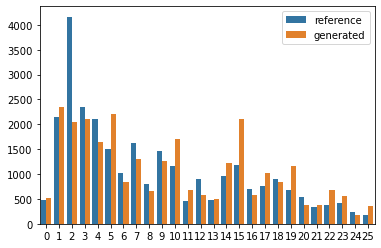

In [13]:
chp = load_and_compare_specNet_clusters('refData.npz')

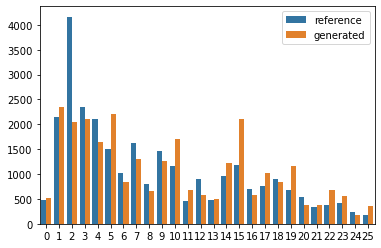

In [10]:
df_clus = chp.compare_Clusters()

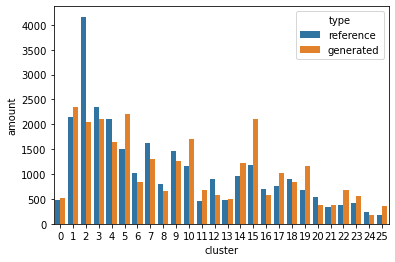

In [12]:
fig1= sns.barplot(x="cluster", y="amount", data=df_clus, hue='type')

In [ ]:
fig1.

,cluster,amount,type
0,0,2881,reference
1,1,4162,reference
2,2,1159,reference
3,3,1643,reference
4,4,2105,reference
5,5,2149,reference
6,6,1486,reference
7,7,1629,reference
8,8,1004,reference
9,9,1016,reference


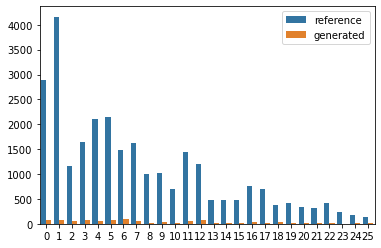

In [15]:
cc.compare_Clusters()

In [6]:
chp = ClusterHelixParams('refData',loadCluster=True)
#chp.silPlot()

In [10]:
chp.featNames

array(['d_1_2', 'd_1_3', 'd_1_4', 'd_2_3', 'd_2_4', 'd_3_4', 'a_1_2',
       'a_1_3', 'a_1_4', 'a_2_3', 'a_2_4', 'a_3_4', 'phi1_1', 'length_1',
       'phi1_2', 'length_2', 'phi1_3', 'length_3', 'phi1_4', 'length_4'],
      dtype=object)

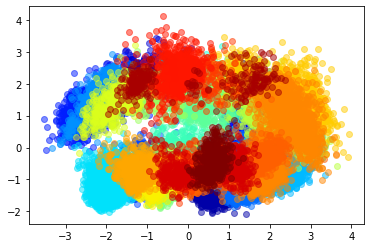

In [13]:
chp.pcaPlot()

In [14]:
#original settings to make this
# chp.sc(n_clusters=26,random_state=0, affinity='nearest_neighbors', n_neighbors=10)
# chp.silPlot()

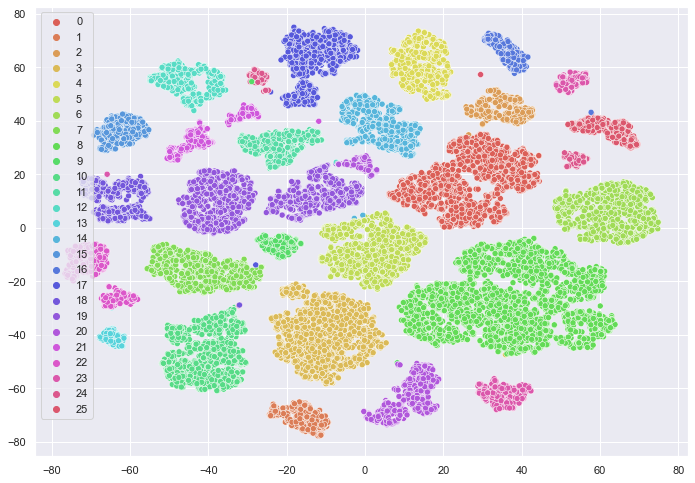

In [15]:
p12 = chp.tSNE_plot()

In [60]:
chp.saveClusters('refData') #saves clustering and scaler for training spectral net and scaling new data

In [19]:
chp_new = ClusterHelixParams('bestGenerator_dist_dihe',load_scaler='refData') #scale the new data using the old scaler
chp_new.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz

In [20]:
chp_new.load_for_spectralNet()

array([10, 10,  1, ...,  4,  2, 18])

,cluster,amount,type
0,0,1192,reference
1,1,4160,reference
2,2,2881,reference
3,3,1495,reference
4,4,2149,reference
5,5,949,reference
6,6,1629,reference
7,7,2107,reference
8,8,531,reference
9,9,955,reference


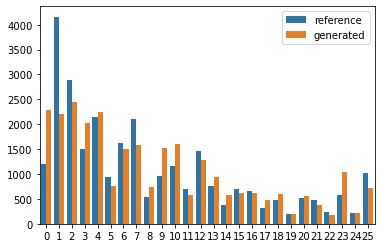

In [21]:
chp_new.compare_Clusters()

In [8]:
chp_new = ClusterHelixParams('gen_dist_dihe_27877',direc='../log/GAN_examples278/',load_scaler='refData') #scale the new data using the old scaler
chp_new.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz

In [9]:
chp_new.load_for_spectralNet()

array([10, 13,  8, ..., 20, 12, 14])

,cluster,amount,type
0,0,1016,reference
1,1,2881,reference
2,2,1192,reference
3,3,4161,reference
4,4,1495,reference
5,5,698,reference
6,6,2149,reference
7,7,759,reference
8,8,955,reference
9,9,2106,reference


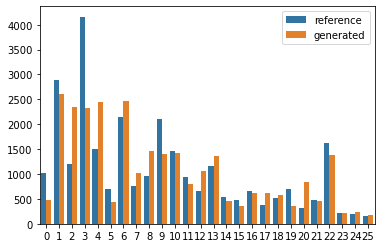

In [10]:
chp_new.compare_Clusters()

In [17]:
together=[0,1,2,8,9,14,15,17,18,19,20,23]#checked manually excludes 21 and 22 which are mixed
apart = [3,4,5,6,7,10,11,12,13,16,24,25] 

In [18]:
tsum = 0
asum = 0
for x in range(chp.n_clusters):
    tot = len(np.where(chp.y_ == x)[0])
    if x in together:
        tsum += tot
    if x in apart:
        asum += tot
    

In [19]:
tsum

15122

In [31]:
np.where(np.array([1])==np.array([1,2,3]))

(array([0], dtype=int64),)

In [85]:
#chp = ClusterHelixParams('dist_dihe_4H')
#chp.sc(n_clusters=28,random_state=0, affinity='nearest_neighbors', n_neighbors=10)
#chp.pcaPlot() #visualization of choice 
#chp.saveClusters('refData') #saves clustering and scaler for training spectral net and scaling new data

In [ ]:
#chp_new = ClusterHelixParams('dist_dihe_BestGenerator',load_scaler='refData') #scale the new data using the old scaler
#chp_new.save_for_spectralNet() # save for loading by spectral net, produces to_predict.npz

In [ ]:
#run Clustering_SpectralNeuralNet to read to_predict.npz and saves 'clusters_specNet.npz' and 'original_clusters.npz'

In [ ]:
#chp_new.load_for_spectralNet() #load and view graphs as desired